In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
RANDOM_STATE = 42

df = pd.read_csv('/content/participant_wise_combined.csv') #present in data folder of github

In [3]:
print(df.shape)
df.head()

(100, 150)


,unnamed: 0,travel_time,subject_id,environment,id,trait_anx,gender,trait_anx_level,pre_saa,post_saa,...,SD_Ch20,SD_Ch21,SD_Ch22,SD_Ch23,SD_Ch24,SD_Ch25,SD_Ch26,F3_F4_theta,F3_Fz_theta,F4_Fz_theta
0,2,3,p2,e1,p2e1,40,F,low,67.926691,33.242639,...,2.205121,2.323949,2.448438,2.559333,2.681443,2.793338,2.942090,0.591511,0.751865,0.831779
1,3,3,p2,e2,p2e2,40,F,low,67.926691,33.242639,...,2.122518,2.236502,2.356954,2.457591,2.579662,2.689818,2.826633,0.655822,0.754214,0.869346
2,4,3,p3,e1,p3e1,45,M,high,2.617566,3.516061,...,1.968179,2.075824,2.174238,2.292225,2.371586,2.488037,2.620785,0.729207,0.850478,0.845125
3,5,3,p3,e2,p3e2,45,M,high,2.617566,3.516061,...,2.039863,2.154719,2.251570,2.377917,2.464296,2.582785,2.716161,0.666994,0.856318,0.810870
4,6,3,p4,e1,p4e1,58,M,high,3.652220,4.352831,...,1.761801,1.860421,1.987060,2.087508,2.143339,2.237350,2.375960,0.908584,0.965320,0.951152


In [4]:
X = df[[col for col in df.columns if "SD" in col]]

In [5]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [6]:
print("Original features:", X.shape[1])
print("After poly expansion:", X_poly.shape[1])

Original features: 26
After poly expansion: 377


In [7]:
y = df["post_cort"] - df["pre_cort"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=RANDOM_STATE
)


In [8]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv = cross_val_score(model, X_poly, y, scoring='r2', cv=5).mean()

    print(f"\n📌 {name}")
    print(f"R2 Score       : {r2:.3f}")
    print(f"RMSE           : {rmse:.3f}")
    print(f"5-Fold CV R2   : {cv:.3f}")

    return {"Model": name, "R2": r2, "RMSE": rmse, "CV_R2": cv}

In [9]:

results = []
results.append(evaluate_model(LinearRegression(), "Linear Regression"))
results.append(evaluate_model(RidgeCV(alphas=[0.1, 1.0, 10.0]), "Ridge Regression"))
results.append(evaluate_model(LassoCV(alphas=[0.001, 0.01, 0.1, 1.0]), "Lasso Regression"))
results.append(evaluate_model(RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE), "Random Forest"))
results.append(evaluate_model(XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE), "XGBoost"))
results.append(evaluate_model(MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_STATE), "MLP Regressor"))




📌 Linear Regression
R2 Score       : -109.911
RMSE           : 101.215
5-Fold CV R2   : -68.223

📌 Ridge Regression
R2 Score       : -5.864
RMSE           : 25.179
5-Fold CV R2   : -2.551


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+03, tolerance: 7.332e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.146e+04, tolerance: 7.332e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+04, tolerance: 7.332e


📌 Lasso Regression
R2 Score       : 0.152
RMSE           : 8.849
5-Fold CV R2   : -0.367

📌 Random Forest
R2 Score       : -1.215
RMSE           : 14.303
5-Fold CV R2   : -0.833

📌 XGBoost
R2 Score       : -5.460
RMSE           : 24.427
5-Fold CV R2   : -3.989

📌 MLP Regressor
R2 Score       : -2.125
RMSE           : 16.989
5-Fold CV R2   : -1.042


In [10]:
results_df = pd.DataFrame(results)
results_df.sort_values("CV_R2", ascending=False).reset_index(drop=True)




,Model,R2,RMSE,CV_R2
0,Lasso Regression,0.152231,8.849052,-0.367240
1,Random Forest,-1.214946,14.303407,-0.832767
2,MLP Regressor,-2.124886,16.989280,-1.042197
3,Ridge Regression,-5.863752,25.179013,-2.550709
4,XGBoost,-5.459749,24.426752,-3.989432
5,Linear Regression,-109.910945,101.215055,-68.222976


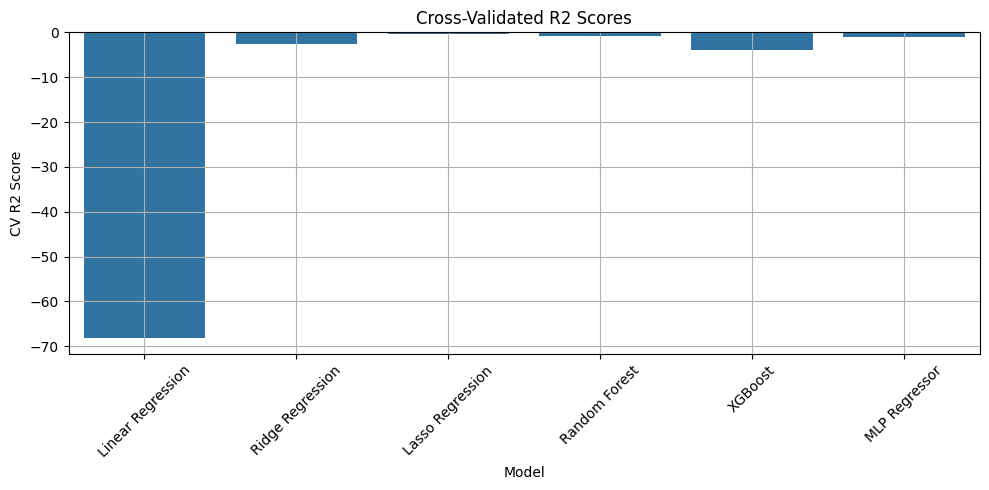

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="CV_R2", data=results_df)
plt.title("Cross-Validated R2 Scores")
plt.ylabel("CV R2 Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()